In [1]:
import import_ipynb
import Scanpy_functions_v03262021 as sc_pipe
import scvelo as scv
scv.logging.print_version()
import warnings
import scirpy as ir
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import bbknn
import logging
from sklearn.mixture import GaussianMixture
from scipy.stats     import norm
import glob
import os
import hvplot.pandas
import docx
from docx import Document
from docx.shared import Inches
from docx.shared import Pt
from scipy import sparse
import scanpy.external as sce
import holoviews as hv
import panel as pn
import bokeh
from bokeh.resources import INLINE
import scanorama
import gseapy

importing Jupyter notebook from Scanpy_functions_v03262021.ipynb
Running scvelo 0.2.3 (python 3.8.5) on 2021-04-20 13:38.


Running scvelo 0.2.3 (python 3.8.5) on 2021-04-20 13:39.


In [2]:
# define sample metadata. Usually read from a file.
exclude_genes = []

samples = {
'GA23428':{},
'GA23429':{},
'GA18593':{},
'GA18594':{},
'GA11556':{},
'GA11557':{}
}

In_path ='/user/ifrec/liuyuchen/scRNASeq_DATA/scRNASeq_BD_Shimizu'
out_path ='/user/ifrec/liuyuchen/scRNASeq_DATA/scRNASeq_BD_Shimizu'
multi_sample = True
sc.settings.verbosity = 3
sc.settings.figdir = out_path+'/figures'

In [3]:
Conditions = {
'GA23428':'Chole',
'GA23429':'Skin',
'GA18593':'Skin',
'GA18594':'Chole',
'GA11556':'Skin',
'GA11557':'Chole'
}

In [4]:
adatalist= []
for sample, sample_meta in samples.items():
    gex_file = In_path+'/'+sample+'_RSEC_ReadsPerCell.csv'      
    gex = sc.read_csv(gex_file)
    genes = [x for x in  gex.var_names]
    gex.var_names = genes
    gex = gex[:,genes[1:]]
    genes = [x.split('|')[0] for x in  gex.var_names]
    gex.var_names = genes
    gex.var_names_make_unique()
    gex.X = sparse.csr_matrix(gex.X)
    gex.obs["Sample"] = sample
    adatalist.append(gex)


In [5]:
adata = sc_pipe.unify_value(adatalist)

In [6]:
adata.obs['Conditions']=adata.obs['Sample'].map(Conditions)

Trying to set attribute `.obs` of view, copying.


In [7]:
%%time
#adata = sc_pipe.qc_and_preprocess(adata, out_path,multi_sample=True)
#adata = sc_pipe.feature_selection(adata,out_path, exclude_genes)
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.scale(adata,  zero_center=False)

normalizing counts per cell
    finished (0:00:00)


CPU times: user 780 ms, sys: 121 ms, total: 901 ms
Wall time: 901 ms


Found 17566 genes among all datasets
[[0.         0.43106111 0.14460597 0.80481283 0.10304731 0.41092328]
 [0.         0.         0.53588092 0.06283422 0.41619888 0.14856957]
 [0.         0.         0.         0.25802139 0.61708099 0.23407022]
 [0.         0.         0.         0.         0.25802139 0.73796791]
 [0.         0.         0.         0.         0.         0.47032879]
 [0.         0.         0.         0.         0.         0.        ]]
Processing datasets (0, 3)
Processing datasets (3, 5)
Processing datasets (2, 4)
Processing datasets (1, 2)
Processing datasets (4, 5)
Processing datasets (0, 1)
Processing datasets (1, 4)
Processing datasets (0, 5)
Processing datasets (3, 4)
Processing datasets (2, 3)
Processing datasets (2, 5)
Processing datasets (1, 5)
Processing datasets (0, 2)
Processing datasets (0, 4)


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:23)
running Leiden clustering
    finished: found 17 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)
... storing 'Sample' as categorical
... storing 'Conditions' as categorical
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


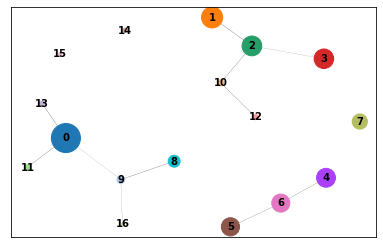

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)


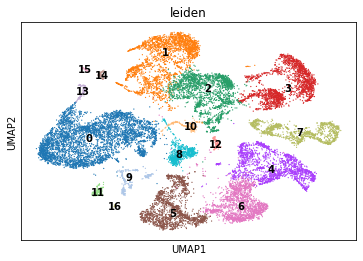

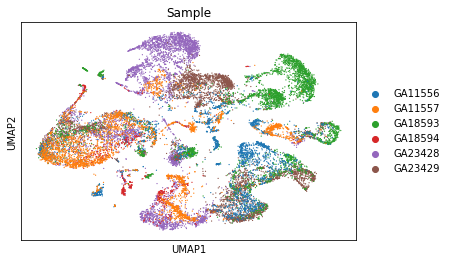

CPU times: user 36min 31s, sys: 2min 9s, total: 38min 41s
Wall time: 14min 45s


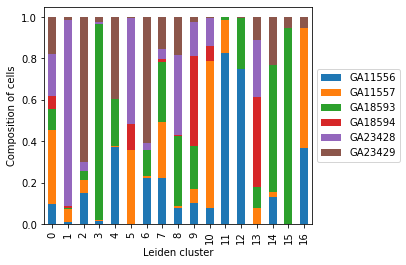

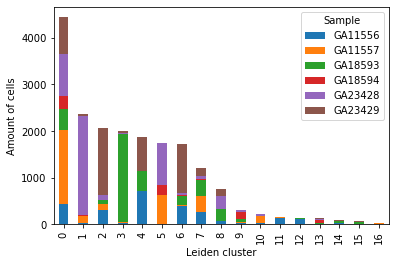

In [8]:
%%time
adata = sc_pipe.clustering(adata,samples,resol=0.3)

In [9]:
adata.obs['Sample'].value_counts()

GA23428    4533
GA23429    4501
GA18593    3921
GA11557    3076
GA11556    2494
GA18594     748
Name: Sample, dtype: int64

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:05)


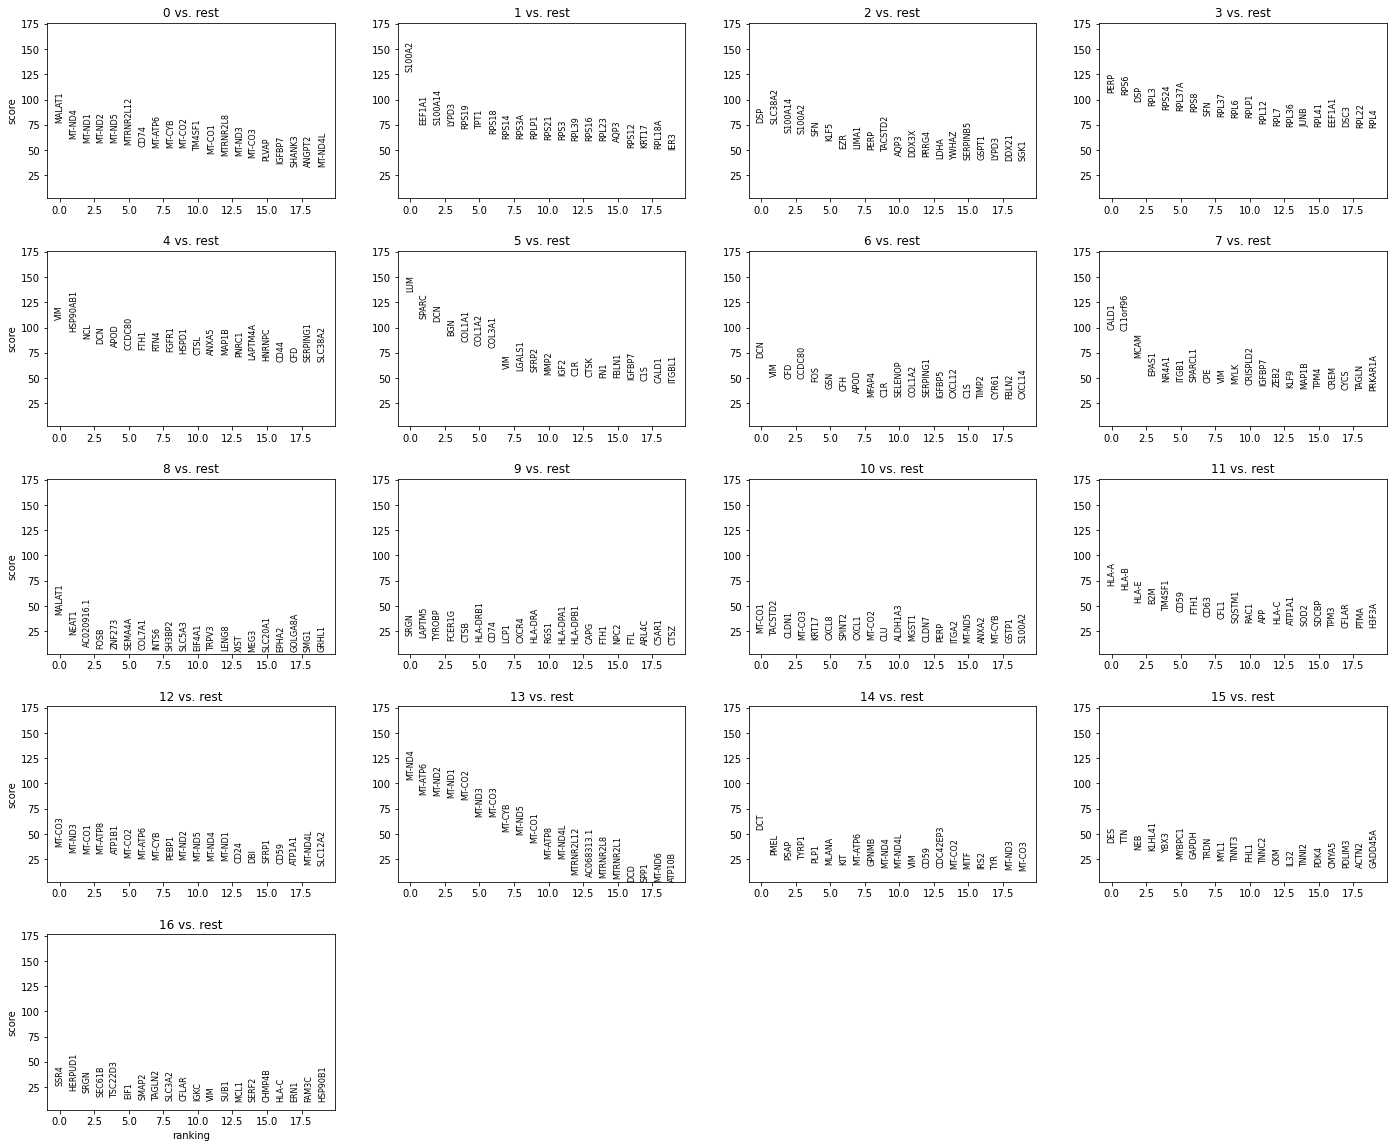

In [10]:
sc.tl.rank_genes_groups(adata, 'leiden',use_raw=False)
sc.pl.rank_genes_groups(adata)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:05)


Wrangling: Number of markers used in ranked_gene_groups:  17566
Wrangling: Groups used for ranking: leiden


... storing 'Cell_typing_Panglao' as categorical


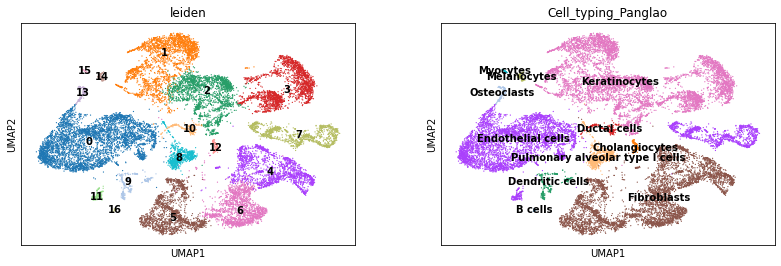

In [11]:
import sys
sys.path.append('/user/ifrec/liuyuchen/scoreCT/src')
import scorect_api as ct
Panglao_markers = pd.read_csv('/user/ifrec/liuyuchen/Gene_markers/PanglaoDB/whole_marker_list.tsv', header=None, sep='\n')
#Panglao_markers = pd.read_csv('/user/ifrec/liuyuchen/Gene_markers/PanglaoDB/GI_tract_markers.tsv', header=None, sep='\n')

ref_marker = Panglao_markers[0].str.split('\t', expand=True).set_index(0).T


sc.tl.rank_genes_groups(adata, groupby='leiden', n_genes=len(adata.var))
marker_df = ct.wrangle_ranks_from_anndata(adata)
# Score cell types for each cluster 
# Let's set parameters first - K represents the number of genes included in the ranking
# m represents the number of bins used to divide the top K genes.
K = 100
m = 10
# Get the background genes - here, all the genes used to run the differential gene expression test
background = adata.var.index.tolist()
# Now run the function
ct_pval, ct_score = ct.celltype_scores(nb_bins=m,
                                        ranked_genes=marker_df,
                                        K_top = K,
                                        marker_ref=ref_marker,
                                        background_genes=background)

cluster_assign = adata.obs['leiden']
celltype_assign = ct.assign_celltypes(cluster_assignment=cluster_assign, ct_pval_df=ct_pval, ct_score_df=ct_score, cutoff=0.1)
# Add to anndata object
adata.obs['Cell_typing_Panglao'] = celltype_assign
sc.pl.umap(adata, color=['leiden','Cell_typing_Panglao'],legend_loc='on data')

In [12]:
rank_genes = pd.DataFrame(adata.uns['rank_genes_groups']['names'])
rank_pavlues = pd.DataFrame(adata.uns['rank_genes_groups']['pvals'])
rank_pavlues.rename(columns=lambda x: x+'_pvals', inplace=True)
rank_fold = pd.DataFrame(adata.uns['rank_genes_groups']['logfoldchanges'])
rank_fold.rename(columns=lambda x: x+'_logfoldchanges', inplace=True)
pd.concat([rank_genes, rank_pavlues,rank_fold], axis=1, join='inner').to_csv(out_path+'/DE_genes_leiden_0420.csv')

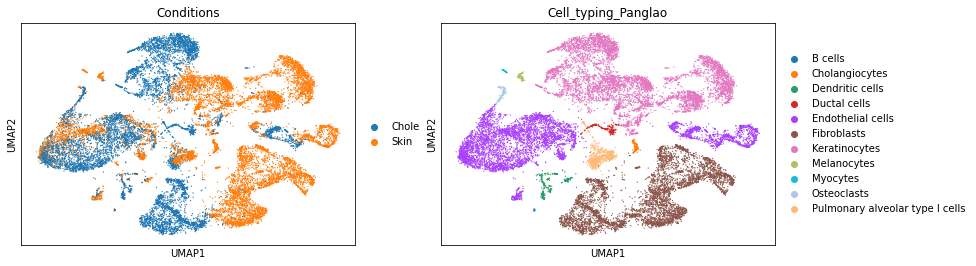

In [13]:
sc.pl.umap(adata, color =['Conditions','Cell_typing_Panglao'])

computing density on 'umap'
--> added
    'umap_density_Conditions', densities (adata.obs)
    'umap_density_Conditions_params', parameter (adata.uns)


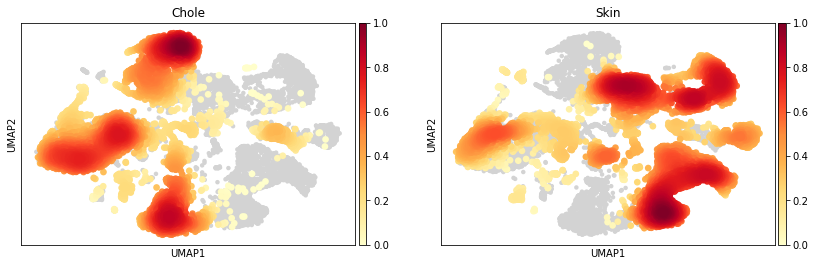

In [14]:
sc.tl.embedding_density(adata, groupby='Conditions')
sc.pl.embedding_density(adata, groupby='Conditions')

computing density on 'umap'
--> added
    'umap_density_Sample', densities (adata.obs)
    'umap_density_Sample_params', parameter (adata.uns)


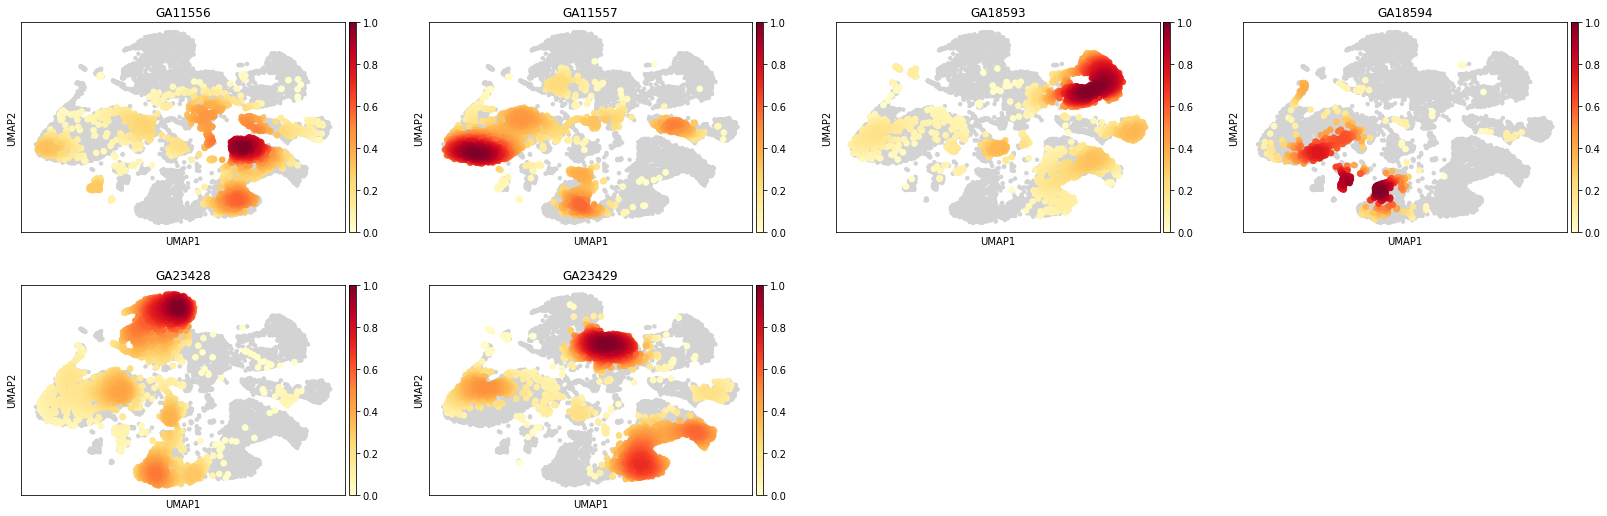

In [15]:
sc.tl.embedding_density(adata, groupby='Sample')
sc.pl.embedding_density(adata, groupby='Sample')

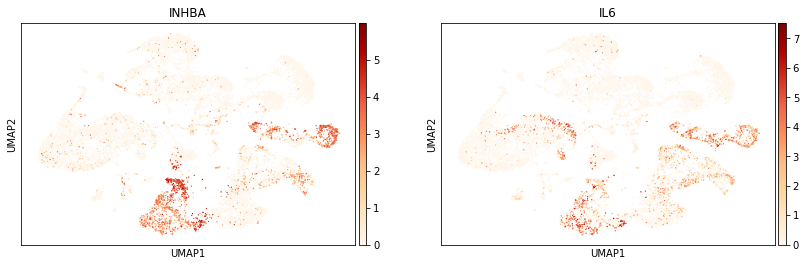

In [16]:
sc.pl.umap(adata, color =['INHBA','IL6'], color_map= 'OrRd',use_raw=False)

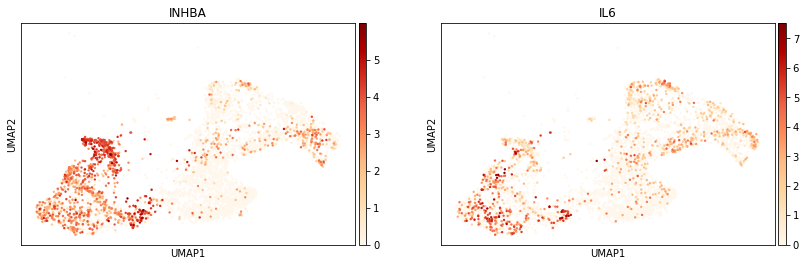

In [17]:
sub = adata[adata.obs['Cell_typing_Panglao']=='Fibroblasts'].copy()
sc.pl.umap(sub, color =['INHBA','IL6'], color_map= 'OrRd',use_raw=False)


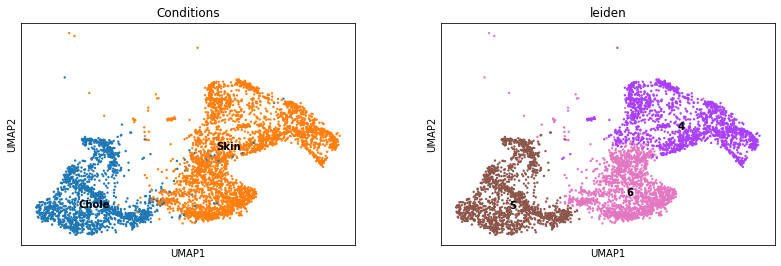

In [18]:
sc.pl.umap(sub, color =['Conditions','leiden'],legend_loc='on data' )

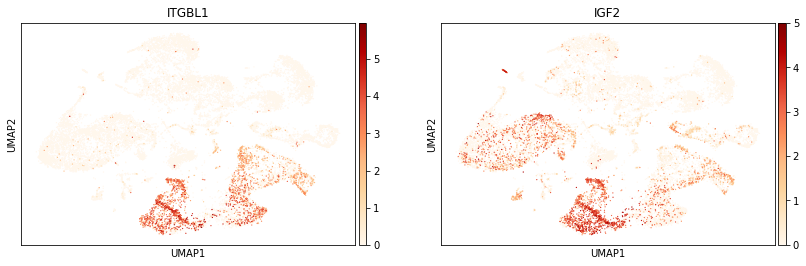

In [19]:
sc.pl.umap(adata, color =['ITGBL1','IGF2'], color_map= 'OrRd',use_raw=False)

In [20]:
adata.write(out_path+'/Merged_anndata_0420.h5')

In [21]:
All_annotation = list(adata.obs.columns)
adata.obs.index.name = 'cell'
sc.external.exporting.cellbrowser(adata, 'Shimitu', 'All_six_samples_0420', annot_keys=All_annotation, cluster_field='leiden',html_dir='Cell_browser_Shimitu')

INFO:root:Creating Shimitu
INFO:root:Writing scanpy matrix (19273 cells, 17566 genes) to Shimitu/exprMatrix.tsv.gz
INFO:root:Transposing matrix
INFO:root:Converting csc matrix to row-sparse matrix
INFO:root:Writing gene-by-gene, without using pandas
INFO:root:Writing 17566 genes in total
INFO:root:Wrote 0 genes
INFO:root:Wrote 2000 genes
INFO:root:Wrote 4000 genes
INFO:root:Wrote 6000 genes
INFO:root:Wrote 8000 genes
INFO:root:Wrote 10000 genes
INFO:root:Wrote 12000 genes
INFO:root:Wrote 14000 genes
INFO:root:Wrote 16000 genes
INFO:root:Writing scanorama coords to Shimitu/scanorama_coords.tsv
INFO:root:Writing UMAP coords to Shimitu/umap_coords.tsv
INFO:root:Writing Shimitu/markers.tsv
INFO:root:Generating Shimitu/quickGenes.tsv from Shimitu/markers.tsv
INFO:root:Assuming marker file format (cluster, gene, score) + any other fields
INFO:root:Wrote Shimitu/cellbrowser.conf
INFO:root:dataRoot is not set in ~/.cellbrowser.conf or via $CBDATAROOT. Dataset hierarchies are not supported.
INF

In [22]:
All_annotation = list(sub.obs.columns)
sub.obs.index.name = 'cell'
sc.external.exporting.cellbrowser(sub, 'Shimitu_sub', 'Fibroblasts_0420', annot_keys=All_annotation, cluster_field='leiden',html_dir='Cell_browser_Shimitu')

INFO:root:Creating Shimitu_sub
INFO:root:Writing scanpy matrix (5346 cells, 17566 genes) to Shimitu_sub/exprMatrix.tsv.gz
INFO:root:Transposing matrix
INFO:root:Converting csc matrix to row-sparse matrix
INFO:root:Writing gene-by-gene, without using pandas
INFO:root:Writing 17566 genes in total
INFO:root:Wrote 0 genes
INFO:root:Wrote 2000 genes
INFO:root:Wrote 4000 genes
INFO:root:Wrote 6000 genes
INFO:root:Wrote 8000 genes
INFO:root:Wrote 10000 genes
INFO:root:Wrote 12000 genes
INFO:root:Wrote 14000 genes
INFO:root:Wrote 16000 genes
INFO:root:Writing scanorama coords to Shimitu_sub/scanorama_coords.tsv
INFO:root:Writing UMAP coords to Shimitu_sub/umap_coords.tsv
INFO:root:Writing Shimitu_sub/markers.tsv
INFO:root:Generating Shimitu_sub/quickGenes.tsv from Shimitu_sub/markers.tsv
INFO:root:Assuming marker file format (cluster, gene, score) + any other fields
INFO:root:Wrote Shimitu_sub/cellbrowser.conf
INFO:root:dataRoot is not set in ~/.cellbrowser.conf or via $CBDATAROOT. Dataset hie

In [24]:
sc.tl.rank_genes_groups(adata, groupby='leiden', use_raw=False, groups=['4','5','6'], key_added='Fibroblasts_ranks')

ranking genes
    finished: added to `.uns['Fibroblasts_ranks']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


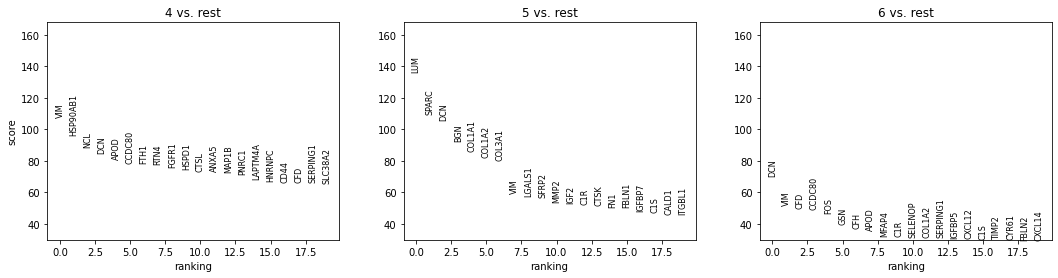

In [25]:
sc.pl.rank_genes_groups(adata, key='Fibroblasts_ranks')

In [31]:
rank_genes = pd.DataFrame(adata.uns['Fibroblasts_ranks']['names'])
rank_pavlues = pd.DataFrame(adata.uns['Fibroblasts_ranks']['pvals'])
rank_pavlues.rename(columns=lambda x: x+'_pvals', inplace=True)
rank_fold = pd.DataFrame(adata.uns['Fibroblasts_ranks']['logfoldchanges'])
rank_fold.rename(columns=lambda x: x+'_logfoldchanges', inplace=True)
pd.concat([rank_genes, rank_pavlues,rank_fold], axis=1, join='inner').to_csv(out_path+'/DE_genes_Fibroblasts_0420.csv')

In [32]:
for c in ['4','5','6']:
    q= rank_genes[c].head(200).tolist()
    sc.queries.enrich(q, org="hsapiens",gprofiler_kwargs={'no_evidences':False}).to_csv(out_path+'/cluster_'+c+'_enrichment.csv')

In [28]:
sc.tl.rank_genes_groups(sub, groupby='Conditions',reference='Skin',use_raw=False)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


In [33]:
rank_genes = pd.DataFrame(sub.uns['rank_genes_groups']['names'])
rank_pavlues = pd.DataFrame(sub.uns['rank_genes_groups']['pvals'])
rank_pavlues.rename(columns=lambda x: x+'_pvals', inplace=True)
rank_fold = pd.DataFrame(sub.uns['rank_genes_groups']['logfoldchanges'])
rank_fold.rename(columns=lambda x: x+'_logfoldchanges', inplace=True)
pd.concat([rank_genes, rank_pavlues,rank_fold], axis=1, join='inner').to_csv(out_path+'/DE_genes_Bycondition_0420.csv')

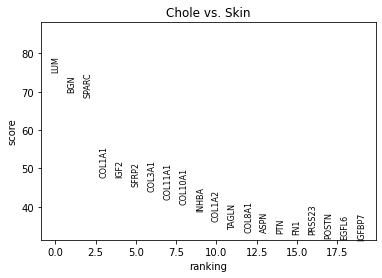

In [29]:
sc.pl.rank_genes_groups(sub, groupby='Conditions',reference='Skin',use_raw=False)

In [34]:
for c in ['Chole']:
    q= rank_genes[c].head(200).tolist()
    sc.queries.enrich(q, org="hsapiens",gprofiler_kwargs={'no_evidences':False}).to_csv(out_path+'/cluster_'+c+'_enrichment.csv')

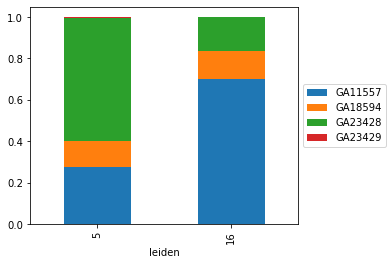

In [35]:
sub2.obs.groupby('leiden')['Sample'].value_counts(normalize = True).unstack().plot.bar(stacked=True)
ax = plt.subplot(111)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))